<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Optional part
## <center> Implementation of the decision tree algorithm

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
%matplotlib inline

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [2]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
    
    A functional to be maximized to find an optimal partition at a given node has the form
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
    For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
    
    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
    
    'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [3]:
def entropy(y):    
    p = np.unique(y, return_counts=True)[1] / np.size(y)
    return -np.sum(np.log2(p) * p)

def gini(y):
    p = np.unique(y, return_counts=True)[1] / np.size(y)
    return 1-np.sum(p**2)

def variance(y):
    n = np.size(y)
    return (1/n)*np.sum((y-(1/n)*np.sum(y))**2)

def mad_median(y):
    n = np.size(y)
    return (1/n)*np.sum(np.abs(y - np.median(y)))

The `Node` class implements a node in the decision tree.

In [4]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [46]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        self.depth = 1
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug
        self.root = None
    
    def __best_split__(self, X, y):
        splits = np.apply_along_axis(self.__max_quality__, axis=0, arr=X, y=y)
        ind = np.argmax(splits[0])
        return (ind, splits[1][ind])
        
    def __max_quality__(self, x, y):
        thresholds = self.__find_thresholds__(x, y)
        qualities = [self.__quality__(x, y, t, self.crit_func) for t in thresholds]
        ind = np.argmax(qualities)
        return (qualities[ind], thresholds[ind])
    
    @staticmethod
    def __quality__(x, y, t, f):
        inds = x < t
        split_l = y[inds]
        split_r = y[~inds]
        return f(y) - (split_l.shape[0]/y.shape[0])*f(split_l) - (split_r.shape[0]/y.shape[0])*f(split_r)
        
    @staticmethod
    def __find_thresholds__(x, y):
        inds = np.argsort(x)
        threshold_inds = np.nonzero(np.diff(y[inds]))[0]
        thresholds = np.unique((x[inds][threshold_inds] + x[inds][threshold_inds + 1]) / 2)
        return thresholds
    
    def __build__(self, node, X, y):
        if ((np.floor(np.log2(self.depth))) < self.max_depth or y.size > self.min_samples_split):
            self.depth += 1
            node.labels = np.unique(y, return_counts=True)
            if (np.unique(y).size == 1):
                return node
            idx, threshold = self.__best_split__(X, y)
            node.feature_idx = idx
            node.threshold = threshold
            inds = X[:, idx] < threshold
            node.left = self.__build__(Node(), X[inds], y[inds])
            node.right = self.__build__(Node(), X[~inds], y[~inds])
        return node
    
    def fit(self, X, y):
        switcher = {'gini':gini,
                   'entropy':entropy,
                   'variance':variance,
                   'mad_median':mad_median}
        self.crit_func = switcher.get(self.criterion)
        root = Node()
        self.__build__(root, X, y)
        self.root = root
        return self
        
    def predict(self, X):
        return np.apply_along_axis(self.__predict_row__, axis=1, arr=X)
    
    def __predict_row__(self, x):
        node = self.root
        while node.left is not None:
            idx = node.feature_idx
            threshold = node.threshold
            labels = node.labels
            if x[idx] < threshold:
                node = node.left
            else:
                node = node.right
        ind = np.argmax(labels[1])
        return labels[0][ind]
        
    def predict_proba(self, X):
        pass

## Testing the implemented algorithm

### Classification

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [6]:
from IPython.core.debugger import set_trace

In [32]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=17)

In [56]:
%%time
tree_e = DecisionTree(10, criterion='entropy')
tree_e.fit(X_train, y_train)
print(accuracy_score(y_test, tree_e.predict(X_test)))

0.861111111111
Wall time: 4.31 s


In [34]:
%%time
tree_g = DecisionTree(4, criterion='gini')
tree_g.fit(X_train, y_train)
print(accuracy_score(y_test, tree_g.predict(X_test)))

0.836111111111
Wall time: 4.12 s


In [54]:
%%time
tree = DecisionTree()
tree_params = {'max_depth': list(range(3, 11)), 
              'criterion': ['gini', 'entropy']}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=1, verbose=True, scoring='accuracy')
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.0min finished


Wall time: 5min 6s


Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

C:\Users\bllgu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\bllgu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


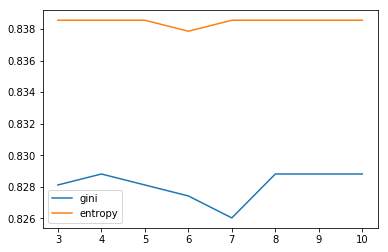

In [51]:
gini_scores = [x.mean_validation_score for x in tree_grid.grid_scores_[0:8]]
entr_scores = [x.mean_validation_score for x in tree_grid.grid_scores_[8:16]]
depths = tree_params['max_depth']
plt.plot(depths, gini_scores, label='gini')
plt.plot(depths, entr_scores, label='entropy')
plt.legend()

In [60]:
tree_grid

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

**1. Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.
2. Created plots have no intersection on the interval [3, 10]
3. Created plots intersect each other only once on the interval [3, 10].
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]

**2. What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [ ]:
# You code here

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [ ]:
# You code here

**3. What is the maximum probability in a resulted vector?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

## Regression

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [ ]:
# You code here

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [ ]:
# You code here

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

In [ ]:
# You code here

**4. Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. Created plots intersect each other only once on the interval [2, 8].
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.

**5. What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.